## Forest estate model


In [1]:
!git submodule init
!git submodule update

In [2]:
%pip install memory_profiler
%load_ext memory_profiler

Note: you may need to restart the kernel to use updated packages.


The following is a hack to force this notebook to use the local `ws3` submodule code.

In [3]:
import os
import sys
import numpy as np
module_path = os.path.abspath(os.path.join('ws3'))
if module_path not in sys.path:
    sys.path.append(module_path)
#sys.path


## Preamble

Import modules, define classes and functions and constants, etc.

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
# %pip install rasterio
# %pip install fiona
# %pip install gurobipy


In [6]:
import ws3.forest, ws3.core
import gurobipy as grb

import matplotlib.pyplot as plt
import pandas as pd
from memory_profiler import profile
import json

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [7]:
data_path = 'data/input'
period_length = 1
max_age = 500
base_year = 2020
horizon = 20
model_name = 'tsa24_clipped'
harvest_acode = 'cc'

# Create a new `ForestModel` instance

In [8]:
fm = ws3.forest.ForestModel(model_name=model_name,
                            model_path=data_path,
                            base_year=base_year,
                            horizon=horizon,
                            period_length=period_length,
                            max_age=max_age)

In [9]:
fm.import_landscape_section()

In [10]:
fm.import_areas_section()

0

In [11]:
fm.import_yields_section()

Note that we have to manually flag the `cc` action as a harvest action (or it will not pass the `is_harvest` gate in `cmp_c_z` when building the optimization model (and there will be no harvest volume to optimize, etc). Currently no way to do this automatically in the `import_actions_section` method, but will try to include something later to avoid having to remember to do this. 

In [12]:
fm.import_actions_section()
fm.actions[harvest_acode].is_harvest = True

Add a "null" action (does nothing). Needed for optimization functions to work. Sort of an obscure design, but that is the way ws3 is implemented for the moment so just roll with it.

In [13]:
fm.add_null_action()

In [14]:
fm.import_transitions_section()

In [15]:
fm.compile_actions()

In [16]:
fm.initialize_areas()
fm.reset_actions()

# Define scenario (add optimization problems)

First we need to define a few utility functions that we will use to build the problems (e.g., objective function coefficient function, even flow constraint coefficient function, general constraint coefficient function).

Note that the `spades_ws3` project contains several useful chunks of code that you can use as a starting point (on GitHub, see link below).

https://github.com/gparadis/spades_ws3/blob/master/python/spadesws3.py

In [17]:
def cmp_c_z(fm, path, expr):
    """
    Compile objective function coefficient (given ForestModel instance, 
    leaf-to-root-node path, and expression to evaluate).
    """
    result = 0.
    for t, n in enumerate(path, start=1):
        d = n.data()
        if fm.is_harvest(d['acode']):
            result += fm.compile_product(t, expr, d['acode'], [d['dtk']], d['age'], coeff=False)
    return result

def cmp_c_cflw(fm, path, expr, mask=None): # product, all harvest actions
    """
    Compile flow constraint coefficient for product indicator (given ForestModel 
    instance, leaf-to-root-node path, expression to evaluate, and optional mask).
    """
    result = {}
    for t, n in enumerate(path, start=1):
        d = n.data()
        if mask and not fm.match_mask(mask, d['dtk']): continue
        if fm.is_harvest(d['acode']):
            result[t] = fm.compile_product(t, expr, d['acode'], [d['dtk']], d['age'], coeff=False)
    return result


def cmp_c_caa(fm, path, expr, acodes, mask=None): # product, named actions
    """
    Compile constraint coefficient for product indicator (given ForestModel 
    instance, leaf-to-root-node path, expression to evaluate, list of action codes, 
    and optional mask).
    """
    result = {}
    for t, n in enumerate(path, start=1):
        d = n.data()
        if mask and not fm.match_mask(mask, d['dtk']): continue
        if d['acode'] in acodes:
            result[t] = fm.compile_product(t, expr, d['acode'], [d['dtk']], d['age'], coeff=False)
    return result


def cmp_c_ci(fm, path, yname, mask=None): # product, named actions
    """
    Compile constraint coefficient for inventory indicator (given ForestModel instance, 
    leaf-to-root-node path, expression to evaluate, and optional mask).
    """
    result = {}
    for t, n in enumerate(path, start=1):
        d = n.data()
        if mask and not fm.match_mask(mask, d['_dtk']): continue
        result[t] = fm.inventory(t, yname=yname, age=d['_age'], dtype_keys=[d['_dtk']]) 
        #result[t] = fm.inventory(t, yname=yname, age=d['age'], dtype_keys=[d['dtk']]) 
    return result

Define a generic base scenario function, and link it to a dispatch function keyed on scenario name string (e.g., `base`). 

Note how we use `functools.partial` to specialize the more general functions defined above for use in the `coeff_funcs` arg of `ForestModel.add_problem`. Otherwise we would have to define an entirely new function each time we defined a slightly different objective or constraint in one of our scenarios, which would get tedious and messy. The tedium and mess would be more evident if we had a large number of alternative scenarios defined in the same notebook (which we do not here, but use your imagination). 

Note also that the expected data structures for the various args to `ForestModel.add_problem` must be matched exactly or `ws3` will likely crash somewhere in one of the series of complicated private optimization model-building methods that get called from `ForestModel.add_problem`. You _should not_ have to unpack the exact logic of this model-building code to figure out why your model is crashing... it really is quite complicated and hard to follow. If you model is crashing there, you probably fed invalid (or incorrectly structured) args to `ForestModel.add_problem`. Carefully review the structure and values of your args to find the problem. I left some notes below (and some comments in the `_gen_scen_base` function code) to help clarify the expected arg structure, and will work on expanding the docstrings in the `ws3` source code so this is less obscure going forward.

I also had to patch the `ws3` code in two places so that it would "grow" correctly with the model set up to use _years_ as the age unit. For some reason the latest `dev` branch of `ws3` on GitHub was in some sort of intermediate state between using _periods_ and _years_ as the age unit. Originally `ws3` was implemented to import and simulate legacy Woodstock model input datasets, so it used _periods_ as the age unit (like Woodstock). At some point I think I hastily patched `ws3` to use _years_ as the age unit to make it work with `spades_ws3` for specific projects that needed to get done and delivered... if I recall we set the period length to 1 year for all those projects so it "just worked", but now we have a bit of a mess. Oops. Ultimately, I will need to revert `ws3` back to using Woodstock-compatible _period_ age unit (but make sure that the `spatial` module can still spatially and temporally disaggregate the aspatial periodic solutions from the Model I LP optimization problems into year-length time slices (maybe with age optionally expressed in years in output from this, for compatibility with downstream linked models like `SpaDES`). This is just a side-effect of many iterations of re-purposing `ws3` to work in a long (ad hoc) sequence of real research projects that had very specific input and output data specs. It is actually remarkable that `ws3` is not _more_ of a mess than it currently is, given the history and essentially null development budget. Use

`ForestModel.add_problem` arg specs are described below.

`name`: String. Used as key to store `Problem` instances in a dict in the `ForestModel` instanace, so make sure it is unique within a given model or you will overwrite dict values (assuming you want to stuff multiple problems, and their solutions, into your model at the same time). 
    
`coeff_funcs`: Dict of function references, keyed on _row name_ strings. These are the functions that generate the LP optimization problem matrix coefficients (for the objective function and constraint rows). This one gets complicated, and is a likely source of bugs. Make sure the row name key strings are all unique or you will make a mess. You can name the constraint rows anything you want, but the objective function row has to be named `z`. All coefficient functions must accept exactly two args, in this order: a `ws3.forest.ForestModel` instance and a `ws3.common.Path` instance. The `z` coefficient function is special in that it must return a single float value. All other (i.e., constraint) coefficient functions just return a dict of floats, keyed on period ints (can be sparse, i.e., not necessary to include key:value pairs in output dict if value is 0.0). It is useful (but not necessary) to use `functools.partial` to specialize a smaller number of more general function definitions (with more args, that get "locked down" and hidden by `partial`) as we have done in the example in this notebook.

`cflw_e`: Dict of `(dict, int)` tuples, keyed on _row name_ strings (must match _row name_ key values used to define coefficient functions for flow constraints in `coeff_func` dict), where the int:float dict embedded in the tuple defines epsilon values keyed on periods (must include all periods, even if epsilon value is always the same). See example below. 

```
{
  'cflw_acut':({1:0.01, 2:0.01, ..., 10:0.01}, 1),
  'cflw_vcut':({1:0.05, 2:0.05, ..., 10:0.05}, 1)
}
```

`cgen_data`: Dict of dict of dicts. The outer-level dict is keyed on _row name_ strings (must match row names used in `coeff_funcs`. The middle second level of dicts always has keys `'lb'` and `'ub'`, and the inner level of dicts specifies lower- and upper-bound general constraint RHS (float) values, keyed on period (int).

`acodes`: List of strings. Action codes to be included in optimization problem formulation (actions must defined in the `ForestModel` instance, but can be only a subset).

`sense`: Must be one of `ws3.opt.SENSE_MAXIMIZE` or `ws3.opt.SENSE_MINIMIZE`.

`mask`: Tuple of strings constituting a valid mask for your `ForestModel` instance. Can be `None` if you do not want to filter `DevelopmentType` instances.

In [18]:
name =[]
def gen_scenario(fm, name=name, util=0.85, harvest_acode='cc', fert_acodes=[],
                 cflw_ha={}, cflw_hv={}, 
                 cgen_gs={}, cgen_ha={}, cgen_hv={}, cgen_fa={},
                 tvy_name='volume', obj_mode='max_hv', mask=None):
    from functools import partial
    import numpy as np
    coeff_funcs = {}
    cflw_e = {}
    cgen_data = {}
    acodes = ['null', harvest_acode] + fert_acodes # define list of action codes
    vexpr = '%s * %0.2f' % (tvy_name, util) # define volume expression
    if obj_mode == 'max_hv': # maximize harvest volume
        sense = ws3.opt.SENSE_MAXIMIZE 
        zexpr = vexpr
    elif obj_mode == 'min_ha': # minimize harvest area
        sense = ws3.opt.SENSE_MINIMIZE 
        zexpr = '1.'
    else:
        raise ValueError('Invalid obj_mode: %s' % obj_mode)        
    coeff_funcs['z'] = partial(cmp_c_z, expr=zexpr) # define objective function coefficient function  
    T = fm.periods
    if cflw_ha: # define even flow constraint (on harvest area)
        cname = 'cflw_ha'
        coeff_funcs[cname] = partial(cmp_c_caa, expr='1.', acodes=[harvest_acode], mask=None) 
        cflw_e[cname] = cflw_ha
    if cflw_hv: # define even flow constraint (on harvest volume)
        cname = 'cflw_hv'
        coeff_funcs[cname] = partial(cmp_c_caa, expr=vexpr, acodes=[harvest_acode], mask=None) 
        cflw_e[cname] = cflw_hv         
    if cgen_gs: # define general constraint (growing stock)
        cname = 'cgen_gs'
        coeff_funcs[cname] = partial(cmp_c_ci, yname=tvy_name, mask=None)
        cgen_data[cname] = cgen_gs
    if cgen_ha: # define general constraint (harvest area)
        cname = 'cgen_ha'
        coeff_funcs[cname] = partial(cmp_c_caa, expr='1.', acodes=[harvest_acode], mask=None) 
        cgen_data[cname] = cgen_ha
    if cgen_hv: # define general constraint (harvest volume)
        cname = 'cgen_hv'
        coeff_funcs[cname] = partial(cmp_c_caa, expr=vexpr, acodes=[harvest_acode], mask=None) 
        cgen_data[cname] = cgen_hv
    if cgen_fa: # define general constraint (fertilized area)
        cname = 'cgen_fa'
        coeff_funcs[cname] = partial(cmp_c_caa, expr='1.', acodes=fert_acodes, mask=None) 
        cgen_data[cname] = cgen_fa
    return fm.add_problem(name, coeff_funcs, cflw_e, cgen_data=cgen_data, acodes=acodes, sense=sense, mask=mask)

Define functions to compile scenario output into a dataframe, and plot this data.

In [19]:
def compile_scenario(fm):
    oha = [fm.compile_product(period, '1.', acode='cc') for period in fm.periods]
    ohv = [fm.compile_product(period, 'volume * 0.85', acode='cc') for period in fm.periods]
    ogs = [fm.inventory(period, 'volume') for period in fm.periods]
    ofa11 = [fm.compile_product(period, '1.', acode='f11') for period in fm.periods] 
    ofa12 = [fm.compile_product(period, '1.', acode='f12') for period in fm.periods] 
    ofa13 = [fm.compile_product(period, '1.', acode='f13') for period in fm.periods] 
    ofa14 = [fm.compile_product(period, '1.', acode='f14') for period in fm.periods] 
    ofa15 = [fm.compile_product(period, '1.', acode='f15') for period in fm.periods] 
    ofa16 = [fm.compile_product(period, '1.', acode='f16') for period in fm.periods] 
    ofa17 = [fm.compile_product(period, '1.', acode='f17') for period in fm.periods] 
    ofa21 = [fm.compile_product(period, '1.', acode='f21') for period in fm.periods] 
    ofa22 = [fm.compile_product(period, '1.', acode='f22') for period in fm.periods] 
    ofa23 = [fm.compile_product(period, '1.', acode='f23') for period in fm.periods] 
    ofa24 = [fm.compile_product(period, '1.', acode='f24') for period in fm.periods] 
    ofa25 = [fm.compile_product(period, '1.', acode='f25') for period in fm.periods] 
    ofa26 = [fm.compile_product(period, '1.', acode='f26') for period in fm.periods] 
    ofa31 = [fm.compile_product(period, '1.', acode='f31') for period in fm.periods] 
    ofa32 = [fm.compile_product(period, '1.', acode='f32') for period in fm.periods] 
    ofa33 = [fm.compile_product(period, '1.', acode='f33') for period in fm.periods] 
    ofa34 = [fm.compile_product(period, '1.', acode='f34') for period in fm.periods] 
    ofa35 = [fm.compile_product(period, '1.', acode='f35') for period in fm.periods]
    data = {'period':fm.periods, 
            'oha':oha, 
            'ohv':ohv, 
            'ogs':ogs, 
            'ofa11':ofa11, 
            'ofa12':ofa12, 
            'ofa13':ofa13, 
            'ofa14':ofa14, 
            'ofa15':ofa15, 
            'ofa16':ofa16, 
            'ofa17':ofa17, 
            'ofa21':ofa21, 
            'ofa22':ofa22, 
            'ofa23':ofa23, 
            'ofa24':ofa24, 
            'ofa25':ofa25, 
            'ofa26':ofa26, 
            'ofa31':ofa31, 
            'ofa32':ofa32, 
            'ofa33':ofa33, 
            'ofa34':ofa34, 
            'ofa35':ofa35}
    df = pd.DataFrame(data)
    return df

In [20]:
def plot_scenario(df):
    fig, ax = plt.subplots(1, 4, figsize=(16, 4))
    ax[0].bar(df.period, df.oha)
    ax[0].set_ylim(0, None)
    ax[0].set_title('Harvested area (ha)')
    ax[1].bar(df.period, df.ohv)
    ax[1].set_ylim(0, None)
    ax[1].set_title('Harvested volume (m3)')
    ax[2].bar(df.period, df.ogs)
    ax[2].set_ylim(0, None)
    ax[2].set_title('Growing Stock (m3)')
    ax[3].bar(df.period, df.ofa11, color='blue', alpha=0.5)
    ax[3].bar(df.period, df.ofa12, color='yellow', alpha=0.5)
    ax[3].bar(df.period, df.ofa13, color='blue', alpha=0.5)
    ax[3].bar(df.period, df.ofa14, color='blue', alpha=0.5)
    ax[3].bar(df.period, df.ofa15, color='red')
    ax[3].bar(df.period, df.ofa16, color='blue', alpha=0.5)
    ax[3].bar(df.period, df.ofa17, color='blue', alpha=0.5)
    # ax[3].bar(df.period, df.ofa21, color='blue', alpha=0.5)
    # ax[3].bar(df.period, df.ofa22, color='blue', alpha=0.5)
    # ax[3].bar(df.period, df.ofa23, color='blue', alpha=0.5)
    # ax[3].bar(df.period, df.ofa24, color='blue', alpha=0.5)
    ax[3].bar(df.period, df.ofa25, color='orange')
    ax[3].bar(df.period, df.ofa26, color='blue', alpha=0.5)
    ax[3].bar(df.period, df.ofa31, color='blue', alpha=0.5)
    ax[3].bar(df.period, df.ofa32, color='blue', alpha=0.5)
    ax[3].bar(df.period, df.ofa33, color='blue', alpha=0.5)
    ax[3].bar(df.period, df.ofa34, color='blue', alpha=0.5)
    ax[3].bar(df.period, df.ofa35, color='yellow')
    #ax[3].legend(fert_acodes)
    ax[3].set_ylim(0, None)
    ax[3].set_title('Fertilized Area (ha)')
    return fig, ax

## Run scenarios

We define some scenario options below. Specify which scenario by setting the `scenario_name` variable below.

In [21]:
# with open('scenario.json', 'r') as f:
#     data = json.load(f)

# # Edit the data
# data['scenario_name'] = 'base'
# data['inventory_retention'] = 1
# data['clt_percentage'] = 0.2

# scenario_name = data["scenario_name"]
# inventory_retention = data["inventory_retention"]
# clt_percentage = data["clt_percentage"]

# # Write the updated data back to the JSON file
# with open('scenario.json', 'w') as f:
#     json.dump(data, f, indent=4)
    


In [22]:
# scenario_name = 'nature'
# scenario_name = 'base'
# scenario_name = 'fert_once'
# scenario_name = 'fert_twice'
# scenario_name = 'fert_thrice'
# scenario_name = 'fert_age10'
# scenario_name = 'f35'
# scenario_name = 'fert_age20'
# scenario_name = 'fert_age30'
# scenario_name = 'fert_age40'
# scenario_name = 'fert_age50'
# scenario_name = 'fert_age60'
# scenario_name = 'fert_age70'

In [23]:
cflw_ha = {}
cflw_hv = {}
cgen_gs = {}
cgen_ha = {}
cgen_hv = {}
cgen_fa = {}
fert_acodes = []


# define growing stock general constraints
# inventory_retention = 1
cgen_gs = {'lb':{x:140000. * inventory_retention for x in range(10,21)}, 'ub':{y:142000. * inventory_retention for y in [20]}}   
# cgen_gs = {'lb':{x:140000. * inventory_retention for x in [20]}, 'ub':{y:150000. * inventory_retention for y in fm.periods}} 
# cgen_gs = {'lb':{p:20000. for p in fm.periods}, 'ub':{p:1000000. for p in fm.periods}}    

# define harvest area and harvest volume flow constraints
# cflw_ha = ({p:0.05 for p in fm.periods}, 10)
cflw_hv = ({p:0.05 for p in fm.periods}, 10)

# define harvest area and harvest volume general constraints
cgen_ha = {'lb':{20:100}, 'ub':{20:150}}    
# cgen_ha = {'lb':{x:0 for x in fm.periods}, 'ub':{y:0 for y in fm.periods}}    

# cgen_hv = {'lb':{x:17500 for x in fm.periods}, 'ub':{y:18000 for y in fm.periods}}    

# define fertilized area general constraints
# cgen_fa = {'lb':{p:50 for p in fm.periods}, 'ub':{p:200 for p in fm.periods}}    


if scenario_name == 'base': 
    # Base scenario
    fert_acodes = []
elif scenario_name == 'nature': 
    # Base scenario, plus one-application fertilization actions
    fert_acodes=[]    
elif scenario_name == 'fert_once': 
    # Base scenario, plus one-application fertilization actions
    fert_acodes=['f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17']
elif scenario_name == 'fert_twice': 
    # Base scenario, plus two-application fertilization actions
    fert_acodes=['f21', 'f22', 'f23', 'f24', 'f25', 'f26']
elif scenario_name == 'fert_thrice': 
    # Base scenario, plus three-application fertilization actions
    fert_acodes=['f31', 'f32', 'f33', 'f34']
# elif scenario_name == 'fert_thrice': 
#     # Base scenario, plus three-application fertilization actions
#     fert_acodes=['f31', 'f32', 'f33', 'f34', 'f35']
elif scenario_name == 'fert_age10': 
    # Base scenario, plus age-10 fertilization actions
    fert_acodes=['f11', 'f21', 'f31']
elif scenario_name == 'f31': 
    # Base scenario, plus age-10 fertilization actions
    fert_acodes=['f31']
elif scenario_name == 'f15': 
    # Base scenario, plus age-10 fertilization actions
    fert_acodes=['f15']
elif scenario_name == 'f25': 
    # Base scenario, plus age-10 fertilization actions
    fert_acodes=['f25']
elif scenario_name == 'f32': 
    # Base scenario, plus age-10 fertilization actions
    fert_acodes=['f32']
elif scenario_name == 'f33': 
    # Base scenario, plus age-10 fertilization actions
    fert_acodes=['f33']
elif scenario_name == 'f34': 
    # Base scenario, plus age-10 fertilization actions
    fert_acodes=['f34']
elif scenario_name == 'f35': 
    # Base scenario, plus age-10 fertilization actions
    fert_acodes=['f35']
elif scenario_name == 'fert_age20': 
    # Base scenario, plus age-20 fertilization actions
    fert_acodes=['f12', 'f22', 'f32']
elif scenario_name == 'fert_age30': 
    # Base scenario, plus age-30 fertilization actions
    fert_acodes=['f13', 'f23', 'f33']
elif scenario_name == 'fert_age40': 
    # Base scenario, plus age-40 fertilization actions
    fert_acodes=['f14', 'f24', 'f34']
elif scenario_name == 'fert_age50': 
    # Base scenario, plus age-50 fertilization actions
    fert_acodes=['f15', 'f25', 'f35']
elif scenario_name == 'fert_age60': 
    # Base scenario, plus age-60 fertilization actions
    fert_acodes=['f16', 'f26']
elif scenario_name == 'fert_age70': 
    # Base scenario, plus age-70 fertilization actions
    fert_acodes=['f17']

%memit
%time

p = gen_scenario(fm=fm, 
                 name=scenario_name, 
                 fert_acodes=fert_acodes, 
                 cflw_ha=cflw_ha, 
                 cflw_hv=cflw_hv,
                 cgen_gs=cgen_gs,
                 cgen_ha=cgen_ha,
                 cgen_hv=cgen_hv,
                 cgen_fa=cgen_fa)

%memit
%time
# fm.reset()
# m = p.solve()
# sch = fm.compile_schedule(p)
# fm.apply_schedule(sch, 
#                   force_integral_area=False, 
#                   override_operability=False,
#                   fuzzy_age=False,
#                   recourse_enabled=False,
#                   verbose=False,
#                   compile_c_ycomps=True)
# df = compile_scenario(fm)
# path = os.path.join('.', 'model_result')
# filename = save_document + '.csv'
# filepath = os.path.join(path, filename)
# df.to_csv(filepath, index=False)

peak memory: 200.38 MiB, increment: 0.17 MiB
CPU times: user 0 ns, sys: 6 µs, total: 6 µs
Wall time: 16.7 µs
peak memory: 233.51 MiB, increment: 0.00 MiB
CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 8.34 µs


You will need to have `gurobipy` installed for this next step to work. At some point I will finish implementing bindings to the PuLP open-source solver library, but for now we are stuck with Gurobi as the only solver that works with ws3. 

You should be able to install `gurobipy` using the magic `%pip` command below, however this _only_ installs the Python module and minimal solver binaries. This _does not_ install the full Gurobi software stack, do the Gurobi licence managent tools (including the `grbgetkey` command) are _not_ installed automatically with the Python module. The `gurobipy` installation includes a limited software license that should allow you to solve _small_ problem instances, but will puke if you try to solve anything too large (which includes most `ws3` problems, unless you model is extremely small and simple). 

If you are eligible for an academic license, you should request and install a "Named-User Acacdemic" license from the Licenses tab in the [Gurobi User Portal](https://portal.gurobi.com/iam/licenses/request) (create a new Gurobi account if you do not have one yet, using your official academic institution email address). This license is per-user, per-machine, is valid for one year, should _only_ be used in an academic context (see [Gurobi Standard EULA](https://cdn.gurobi.com/wp-content/uploads/Gurobi_Standard_EULA_Nov2022.pdf) for details of license terms and restrictions).

**Hint:** If you get a `grbgetkey: command not found` error, either the full Gurobi software stack is not installed at all on your system, or is installed but `grbgetkey` is not in your path. Depending on your situation, either [install the full Gurobi software stack](https://support.gurobi.com/hc/en-us/articles/4534161999889) or specify the full path to the `grbgetkey` command (I usually install Gurobi in `/opt/gurobi` when setting up my development VMs).   

In [24]:
fm.reset()

Solve the optimization problem. Note that we stash a reference to the lower-level `gurobi.Model` object in case we need or want to poke around it (can yield insight into how the optimization problem is formulated on the solver side of things, or help debug).

Be vigilant for "infeasible or unbounded model" messages and such below, in case these are unexpected. Depending on how the rest of the model was set up, `ws3` may automatically attempt to resolve infeasible models using "feasibility relaxation" mode in Gurobi (which might not be what you want, depending on the situation).

In [25]:
m = p.solve()

Set parameter Username
Academic license - for non-commercial use only - expires 2024-02-22
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel Xeon Processor (Skylake, IBRS), instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 72 rows, 1863 columns and 32358 nonzeros
Model fingerprint: 0x9005f273
Coefficient statistics:
  Matrix range     [4e-01, 1e+05]
  Objective range  [3e+01, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+05]
Presolve removed 4 rows and 0 columns
Presolve time: 0.02s
Presolved: 68 rows, 1865 columns, 30636 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 2.112e+03
 Factor NZ  : 2.346e+03 (roughly 1 MB of memory)
 Factor Ops : 1.071e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective     

If the model solved to optimality, simulate the optimal solution.

In [26]:
if m.status != grb.GRB.OPTIMAL:
    print('Model not optimal.')
    sys.exit()
sch = fm.compile_schedule(p)
fm.apply_schedule(sch, 
                  force_integral_area=False, 
                  override_operability=False,
                  fuzzy_age=False,
                  recourse_enabled=False,
                  verbose=False,
                  compile_c_ycomps=True)

0.0

In [27]:
df = compile_scenario(fm)
mean_volume = df['ohv'].mean()
print(mean_volume)


17340.32435334414


In [28]:
df

,period,oha,ohv,ogs,ofa11,ofa12,ofa13,ofa14,ofa15,ofa16,...,ofa22,ofa23,ofa24,ofa25,ofa26,ofa31,ofa32,ofa33,ofa34,ofa35
0,1,99.910924,18271.047822,136497.549621,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,98.152285,18271.047822,139517.057228,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,100.606331,18271.047822,139953.674759,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,77.229889,16530.948030,141643.229359,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,59.709899,16530.948030,143572.780879,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,6,60.829846,16530.948030,143896.242699,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,7,80.954924,16530.948030,143043.988297,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,8,83.766904,16530.948030,142231.691866,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,9,80.553727,16530.948030,141152.059039,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,10,53.932349,17400.997926,140000.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
# sch

# Convert the management pland and HWP volume into csv document

In [30]:
extracted_columns = df[['period', 'oha']]

df['summary'] = df[['ofa11', 'ofa12', 'ofa13', 'ofa14', 'ofa15', 'ofa16', 'ofa17', 'ofa21', 'ofa22', 'ofa23', 'ofa24', 'ofa25', 'ofa26', 'ofa31', 'ofa32', 'ofa33', 'ofa34', 'ofa35']].sum(axis=1)

df_operation_area = extracted_columns.copy()
df_operation_area['fert_area'] = df['summary']

df_operation_area.to_csv(f"model_result/emission_calculation/operation_area_{scenario_name}.csv")
df_operation_area

,period,oha,fert_area
0,1,99.910924,0.0
1,2,98.152285,0.0
2,3,100.606331,0.0
3,4,77.229889,0.0
4,5,59.709899,0.0
5,6,60.829846,0.0
6,7,80.954924,0.0
7,8,83.766904,0.0
8,9,80.553727,0.0
9,10,53.932349,0.0


In [31]:
df.to_csv(f"model_result/management_plan/management_plan_{scenario_name}.csv")


In [32]:
data_product = {
    'period': fm.periods,
    'volume': [fm.compile_product(i, 'volume') for i in fm.periods],
    'plumber': [fm.compile_product(i, 'plumber') * 0.0023597372 for i in fm.periods],#covert bf to m3
    'pbark': [fm.compile_product(i, 'pbark') for i in fm.periods],
    'pchips': [fm.compile_product(i, 'pchips') for i in fm.periods],
    'psawdust': [fm.compile_product(i, 'psawdust') for i in fm.periods],
    'pshaving': [fm.compile_product(i, 'pshaving') for i in fm.periods],
    'ptrim': [fm.compile_product(i, 'ptrim') for i in fm.periods]
}

df_product = pd.DataFrame(data_product)

df_product.drop('volume', axis=1, inplace=True)
# df_product.to_csv(f"model_result/hwp_volume/hwp_volume_{scenario_name}.csv")
# df_product.to_csv(f"model_result/emission_calculation/hwp_volume_{scenario_name}.csv")

In [33]:
df_product

,period,plumber,pbark,pchips,psawdust,pshaving,ptrim
0,1,17598.139716,733.676469,2376.151256,499.554621,243.721848,143.810924
1,2,17550.983600,687.065994,2355.654836,490.761424,294.456855,196.304570
2,3,17622.997688,734.681108,2384.419195,512.631655,222.049453,121.443122
3,4,15875.769674,639.325440,2097.356027,459.562533,250.296496,173.066607
4,5,15827.213544,662.492729,2044.417271,474.766162,238.839595,176.216668
5,6,15246.081056,625.644651,2005.005625,458.676027,257.398470,177.368624
6,7,15806.400410,679.551552,2111.631540,428.708740,250.842812,169.887888
7,8,15803.372004,670.135233,2123.678504,418.834520,251.300712,167.533808
8,9,15786.568048,665.009090,2120.247588,418.203091,249.378409,166.252273
9,10,16405.877258,699.907108,2118.103248,478.454880,281.107410,167.519879


In [34]:
# import os
# path = os.path.join('.', 'model_result')
# filename = save_document + '.csv'
# filepath = os.path.join(path, filename)
# df.to_csv(filepath, index=False)

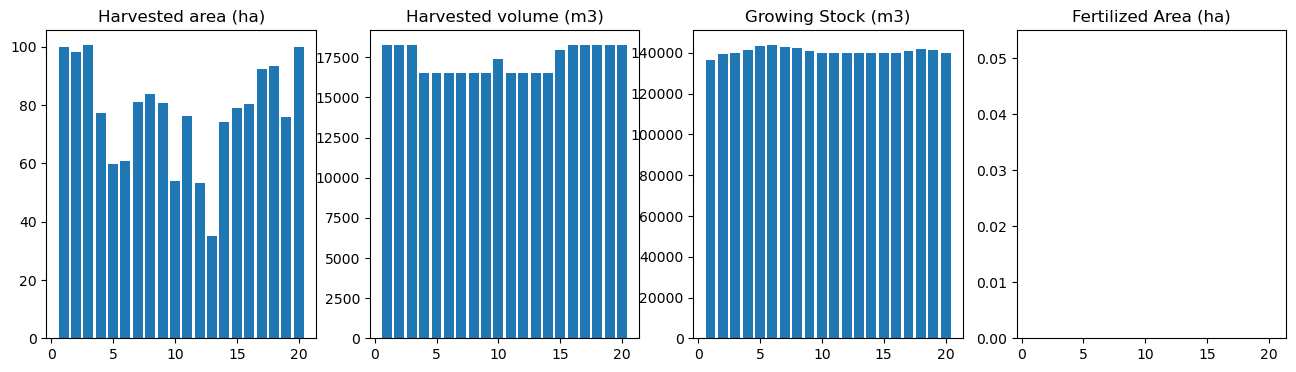

In [35]:
fig, ax = plot_scenario(df)

## Carbon sequestration calculation

In [36]:
data_carbon_seq = {'period': [], 'co2_seq': []}

for i in range(1, 21):
    period_value = i
    if i == 1:
        co2_value = fm.compile_product(i, 'volume') * 460 * 0.5 * 44 / 12 #0.5 is the average carbon intensity for wood and convert carbon content to co2 eq
        data_carbon_seq['period'].append(period_value)
        data_carbon_seq['co2_seq'].append(co2_value)
    else:    
        co2_value = (fm.compile_product(i, 'volume') + fm.inventory(i, 'volume') - fm.inventory(i - 1, 'volume')) * 460 * 0.5 * 44 / 12 #0.5 is the average carbon intensity for wood

        data_carbon_seq['period'].append(period_value)
        data_carbon_seq['co2_seq'].append(co2_value)
    
df_carbon_seq = pd.DataFrame(data_carbon_seq)
# df_carbon_seq.to_csv(f"model_result/emission_calculation/co2_sequestration_{scenario_name}.csv")
df_carbon_seq

,period,co2_seq
0,1,1.812775e+07
1,2,2.067420e+07
2,3,1.849596e+07
3,4,1.782615e+07
4,5,1.802855e+07
5,6,1.667408e+07
6,7,1.568256e+07
7,8,1.571626e+07
8,9,1.549080e+07
9,10,1.629295e+07


In [37]:
fm.inventory(1,'volume')

136497.54962102542

## The following section is the CBM sequential running section

In [38]:
import libcbm
libcbm.__path__

['/opt/jupyterhub/lib/python3.10/site-packages/libcbm']

In [39]:
species_classifier_colname = 'species'
leading_species_classifier_colname = 'leading_species'

In [40]:
nv = 300 # this MIGHT have to match the number of ages classes in sit_age_classes (not sure)

In [41]:
data = {'theme0':[], 'theme1':[], 'theme2':[], 'theme3':[], 'theme4':[], 
        species_classifier_colname:[], leading_species_classifier_colname:[], 
        **{'v%i' % i:[] for i in range(nv + 1)}}

In [42]:
canfi_species = pd.read_csv('data/canfi_species.csv')
canfi_species.set_index('canfi_species', inplace=True)

In [43]:
leading_species_from_dtype_key = {} # we will need this later (as leading_species needs to be a "classifier" in libcbm

for dtype_key, ytype, curves in fm.yields[:-1]:
    if ytype != 'a': continue
    for yname, curve in curves:
        if yname.startswith('s'):
            for i in range(5): data['theme%i' % i].append(dtype_key[i])
            species = 'softwood' if int(yname[-4:]) < 1200 else 'hardwood' # CANFI species codes happen to be sorted by softwood/hardwood 
            leading_species_from_dtype_key[dtype_key] = species
            data[species_classifier_colname].append(species)
            data[leading_species_classifier_colname].append(species) # just a weird libcbm data model thing...
            #data['foo'].append(species)
            #data['bar'].append(species) # just a weird libcbm data model thing...
            # for i in range(nv + 1): data['v%i' % i].append(curve[i * 10])
            for i in range(nv + 1): data['v%i' % i].append(curve[i] * 0.87)


In [44]:
sit_yield = pd.DataFrame(data)
sit_yield.to_csv('data_cbm/sit_yield.csv', index=False)

In [45]:
sit_yield

,theme0,theme1,theme2,theme3,theme4,species,leading_species,v0,v1,v2,...,v291,v292,v293,v294,v295,v296,v297,v298,v299,v300
0,?,?,2402000,?,2422000,softwood,softwood,0.0,0.0,0.0,...,412.38,412.38,412.38,412.38,412.38,412.38,412.38,412.38,412.38,412.38
1,?,?,2403000,?,2423000,softwood,softwood,0.0,0.0,0.0,...,535.05,535.05,535.05,535.05,535.05,535.05,535.05,535.05,535.05,535.05
2,?,?,2403001,?,2423001,softwood,softwood,0.0,0.0,0.0,...,412.38,412.38,412.38,412.38,412.38,412.38,412.38,412.38,412.38,412.38
3,?,?,2401002,?,2421002,softwood,softwood,0.0,0.0,0.0,...,243.60,243.60,243.60,243.60,243.60,243.60,243.60,243.60,243.60,243.60
4,?,?,2402002,?,2422002,softwood,softwood,0.0,0.0,0.0,...,366.27,366.27,366.27,366.27,366.27,366.27,366.27,366.27,366.27,366.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242,?,?,2402004,?,2422354,softwood,softwood,0.0,0.0,0.0,...,368.01,368.01,368.01,368.01,368.01,368.01,368.01,368.01,368.01,368.01
243,?,?,2403004,?,2423354,softwood,softwood,0.0,0.0,0.0,...,481.98,481.98,481.98,481.98,481.98,481.98,481.98,481.98,481.98,481.98
244,?,?,2401007,?,2421357,softwood,softwood,0.0,0.0,0.0,...,451.53,451.53,451.53,451.53,451.53,451.53,451.53,451.53,451.53,451.53
245,?,?,2402007,?,2422357,softwood,softwood,0.0,0.0,0.0,...,538.53,538.53,538.53,538.53,538.53,538.53,538.53,538.53,538.53,538.53


In [46]:
names = ['_', 'theme0', 'theme1', 'theme2', 'theme3', 'theme4', 'age', 'area']
sit_inventory = pd.read_csv('data/woodstock_model_files/tsa24_clipped.are', 
                            delimiter=' ', header=None, names=names)
# sit_inventory['theme4'] = sit_inventory['theme4'].astype(int)

sit_inventory['theme4'] = sit_inventory['theme4'].apply(lambda x: x + 20000 if x < 2420000 else x)
sit_inventory.head()

,_,theme0,theme1,theme2,theme3,theme4,age,area
0,*A,tsa24_clipped,1,2401002,204,2421002,78,103.767403
1,*A,tsa24_clipped,1,2401002,204,2421002,80,4.173147
2,*A,tsa24_clipped,1,2401002,204,2421002,85,282.129636
3,*A,tsa24_clipped,1,2401002,204,2421002,91,73.102156
4,*A,tsa24_clipped,1,2401002,204,2421002,93,28.379567


In [47]:
sit_inventory.drop('_', axis=1, inplace=True)

In [48]:
def _leading_species(dtype_key):
    for mask, leading_species in leading_species_from_dtype_key.items():
        if fm.match_mask(mask, dtype_key):
            return leading_species
        
def __leading_species(r):
    dtype_key = tuple(str(r['theme%i' % i]) for i in range(5))
    return _leading_species(dtype_key)

In [49]:
# sit_inventory[species_classifier_colname] = sit_inventory.apply(__leading_species, axis=1)
sit_inventory['theme3'] = sit_inventory['theme3'].astype(int)  # Convert 'theme3' column to integers

sit_inventory['species'] = sit_inventory['theme3'].apply(lambda x: 'softwood' if x < 1200 else 'hardwood')

sit_inventory['using_age_class'] = 'FALSE'
sit_inventory['delay'] = 0
sit_inventory['landclass'] = 0
sit_inventory['historic_disturbance'] = 'fire'
sit_inventory['last_pass_disturbance'] = sit_inventory.apply(lambda r: 'fire' if r['theme2'] == r['theme4'] else 'harvest', axis=1)

In [50]:
names = ['theme0', 'theme1', 'theme2', 'theme3', 'theme4', species_classifier_colname,
         'using_age_class', 'age', 'area', 'delay', 'landclass', 
         'historic_disturbance', 'last_pass_disturbance']
sit_inventory = sit_inventory[names]
sit_inventory = sit_inventory[sit_inventory['theme1'] != 0]
# sit_inventory['age'] = (sit_inventory['age']/10).round()
# sit_inventory['age'] = sit_inventory['age']
sit_inventory['age'] = np.round(sit_inventory['age'], -1)-10
sit_inventory.to_csv('data_cbm/sit_inventory.csv', index=False)
sit_inventory

,theme0,theme1,theme2,theme3,theme4,species,using_age_class,age,area,delay,landclass,historic_disturbance,last_pass_disturbance
0,tsa24_clipped,1,2401002,204,2421002,softwood,FALSE,70,103.767403,0,0,fire,harvest
1,tsa24_clipped,1,2401002,204,2421002,softwood,FALSE,70,4.173147,0,0,fire,harvest
2,tsa24_clipped,1,2401002,204,2421002,softwood,FALSE,70,282.129636,0,0,fire,harvest
3,tsa24_clipped,1,2401002,204,2421002,softwood,FALSE,80,73.102156,0,0,fire,harvest
4,tsa24_clipped,1,2401002,204,2421002,softwood,FALSE,80,28.379567,0,0,fire,harvest
5,tsa24_clipped,1,2401002,204,2421002,softwood,FALSE,90,94.946760,0,0,fire,harvest
6,tsa24_clipped,1,2401002,204,2421002,softwood,FALSE,90,32.175419,0,0,fire,harvest
7,tsa24_clipped,1,2401002,204,2421002,softwood,FALSE,100,4.184826,0,0,fire,harvest
8,tsa24_clipped,1,2401002,204,2421002,softwood,FALSE,110,50.030817,0,0,fire,harvest
9,tsa24_clipped,1,2401002,204,2421002,softwood,FALSE,110,78.166121,0,0,fire,harvest


In [51]:
data = {'classifier_id':[], 'name':[], 'description':[]}
for i in range(5):
    data['classifier_id'].append(i+1)
    data['name'].append('_CLASSIFIER')
    data['description'].append('theme%i' % i)
    for v in fm.theme_basecodes(i):
        data['classifier_id'].append(i+1)
        data['name'].append(v)
        data['description'].append(v) # these are not very good descriptions, but will not affect CBM model output

        
# ['2401000' '2401002' '2402000' '2402002' '2402005' '2403000' '2403002']
data['classifier_id'].append(5)
data['name'].append('2401000')
data['description'].append('2401000') 

data['classifier_id'].append(5)
data['name'].append('2401002')
data['description'].append('2401002')

data['classifier_id'].append(5)
data['name'].append('2402000')
data['description'].append('2402000') 

data['classifier_id'].append(5)
data['name'].append('2402002')
data['description'].append('2402002') 

data['classifier_id'].append(5)
data['name'].append('2402005')
data['description'].append('2402005') 

data['classifier_id'].append(5)
data['name'].append('2403000')
data['description'].append('2403000')

data['classifier_id'].append(5)
data['name'].append('2403002')
data['description'].append('2403002') 


data['classifier_id'].append(6)
data['name'].append('_CLASSIFIER')
data['description'].append(species_classifier_colname) 

data['classifier_id'].append(6)
data['name'].append('softwood')
data['description'].append('softwood') 

data['classifier_id'].append(6)
data['name'].append('hardwood')
data['description'].append('hardwood') 

sit_classifiers = pd.DataFrame(data)
sit_classifiers.to_csv('data_cbm/sit_classifiers.csv', index=False)
sit_classifiers

,classifier_id,name,description
0,1,_CLASSIFIER,theme0
1,1,tsa24_clipped,tsa24_clipped
2,2,_CLASSIFIER,theme1
3,2,0,0
4,2,1,1
...,...,...,...
498,5,2403000,2403000
499,5,2403002,2403002
500,6,_CLASSIFIER,species
501,6,softwood,softwood


In [52]:
data = {'id':['harvest', 'fire','f11','f12','f13','f14','f15','f16','f17','f21','f22','f23','f24','f25','f26','f31','f32','f33','f34','f35'], 
        'name':['harvest', 'fire','plant','plant','plant','plant','plant','plant','plant','plant','plant','plant','plant','plant','plant','plant','plant','plant','plant','plant']}
sit_disturbance_types = pd.DataFrame(data)
sit_disturbance_types.to_csv('data_cbm/sit_disturbance_types.csv', index=False)
sit_disturbance_types

,id,name
0,harvest,harvest
1,fire,fire
2,f11,plant
3,f12,plant
4,f13,plant
5,f14,plant
6,f15,plant
7,f16,plant
8,f17,plant
9,f21,plant


In [53]:
# data = {'name':['age_0'],
#         'class_size':[0],
#         'start_year':[0],
#         'end_year':[0]}
# max_age = 100
# for i, ac in enumerate(range(period_length, max_age+period_length, period_length)):
#     data['name'].append('age_%i' % (i+1))
#     data['class_size'].append(period_length)
#     data['start_year'].append(ac - period_length + 1)
#     data['end_year'].append(ac)
# sit_age_classes = pd.DataFrame(data)
# sit_age_classes.to_csv('data_cbm/sit_age_classes.csv', index=False)
# sit_age_classes

In [54]:
# age class test
sit_age_classes = pd.read_csv('data/libcbm_model_files/sit_age_classes.csv')

In [55]:
columns = ['theme0',
           'theme1',
           'theme2',
           'theme3',
           'theme4',
           species_classifier_colname,
           'using_age_class',
           'min_softwood_age',
           'max_softwood_age',
           'min_hardwood_age',
           'max_hardwood_age',
           'MinYearsSinceDist',
           'MaxYearsSinceDist',
           'LastDistTypeID',
           'MinTotBiomassC',
           'MaxTotBiomassC',
           'MinSWMerchBiomassC',
           'MaxSWMerchBiomassC',
           'MinHWMerchBiomassC',
           'MaxHWMerchBiomassC',
           'MinTotalStemSnagC',
           'MaxTotalStemSnagC',	
           'MinSWStemSnagC',
           'MaxSWStemSnagC',
           'MinHWStemSnagC',
           'MaxHWStemSnagC',
           'MinTotalStemSnagMerchC',
           'MaxTotalStemSnagMerchC',
           'MinSWMerchStemSnagC',
           'MaxSWMerchStemSnagC',
           'MinHWMerchStemSnagC',
           'MaxHWMerchStemSnagC',
           'efficiency',
           'sort_type',
           'target_type',
           'target',
           'disturbance_type',
           'disturbance_year']

In [56]:
data = {c:[] for c in columns}

In [57]:

# for dtype_key, age, area, acode, period, _ in sch:
#     for i in range(5): data['theme%i' % i].append(dtype_key[i])
#     data[species_classifier_colname].append(_leading_species(dtype_key))
#     data['using_age_class'].append('FALSE')
#     data['min_softwood_age'].append(-1)
#     data['max_softwood_age'].append(-1)
#     data['min_hardwood_age'].append(-1)
#     data['max_hardwood_age'].append(-1)
#     for c in columns[11:-6]: data[c].append(-1)
#     data['efficiency'].append(1)
#     data['sort_type'].append(3) # oldest first (see Table 3-3 in the CBM-CFS3 user guide)
#     data['target_type'].append('A') # area target
#     data['target'].append(area)
#     data['disturbance_type'].append(acode)
#     data['disturbance_year'].append(period*fm.period_length*10)
# sit_events = pd.DataFrame(data)
# sit_events.loc[sit_events['disturbance_type'] == 'cc', 'disturbance_type'] = 'harvest'
# sit_events

In [58]:

for dtype_key, age, area, acode, period, _ in sch:
    for i in range(5): data['theme%i' % i].append(dtype_key[i])
    data[species_classifier_colname].append(_leading_species(dtype_key))
    data['using_age_class'].append('FALSE')
    data['min_softwood_age'].append((age)*10-1)
    data['max_softwood_age'].append((age)*10+1)
    data['min_hardwood_age'].append(-1)
    data['max_hardwood_age'].append(-1)
    data['MinYearsSinceDist'].append(-1)
    data['MaxYearsSinceDist'].append(-1)
    for c in columns[13:-6]: data[c].append(-1)
    data['efficiency'].append(1)
    data['sort_type'].append(2) 
    data['target_type'].append('A') # area target
    data['target'].append(area)
    data['disturbance_type'].append(acode)
    data['disturbance_year'].append(period*fm.period_length*10)
sit_events = pd.DataFrame(data)
sit_events.loc[sit_events['disturbance_type'] == 'cc', 'disturbance_type'] = 'harvest'
sit_events

,theme0,theme1,theme2,theme3,theme4,species,using_age_class,min_softwood_age,max_softwood_age,min_hardwood_age,...,MinSWMerchStemSnagC,MaxSWMerchStemSnagC,MinHWMerchStemSnagC,MaxHWMerchStemSnagC,efficiency,sort_type,target_type,target,disturbance_type,disturbance_year
0,tsa24_clipped,1,2401002,204,2421002,softwood,FALSE,139,141,-1,...,-1,-1,-1,-1,1,2,A,54.033045,harvest,10
1,tsa24_clipped,1,2401002,204,2421002,softwood,FALSE,139,141,-1,...,-1,-1,-1,-1,1,2,A,1.977879,harvest,10
2,tsa24_clipped,1,2401002,204,2421002,softwood,FALSE,149,151,-1,...,-1,-1,-1,-1,1,2,A,8.859900,harvest,10
3,tsa24_clipped,1,2401002,204,2421002,softwood,FALSE,149,151,-1,...,-1,-1,-1,-1,1,2,A,0.740100,harvest,10
4,tsa24_clipped,1,2401002,204,2421002,softwood,FALSE,159,161,-1,...,-1,-1,-1,-1,1,2,A,34.300000,harvest,10
5,tsa24_clipped,1,2401002,204,2421002,softwood,FALSE,149,151,-1,...,-1,-1,-1,-1,1,2,A,13.494231,harvest,20
6,tsa24_clipped,1,2401002,204,2421002,softwood,FALSE,149,151,-1,...,-1,-1,-1,-1,1,2,A,84.658054,harvest,20
7,tsa24_clipped,1,2401002,204,2421002,softwood,FALSE,139,141,-1,...,-1,-1,-1,-1,1,2,A,47.997474,harvest,30
8,tsa24_clipped,1,2401002,204,2421002,softwood,FALSE,139,141,-1,...,-1,-1,-1,-1,1,2,A,34.972066,harvest,30
9,tsa24_clipped,1,2401002,204,2421002,softwood,FALSE,159,161,-1,...,-1,-1,-1,-1,1,2,A,14.436791,harvest,30


In [59]:
sit_events.to_csv('data_cbm/sit_events.csv', index=False)

In [60]:
au_table = pd.read_csv('data/au_table.csv')
au_table1 = au_table.set_index('au_id')
au_table2 = au_table.set_index('managed_curve_id')
# au_table1

In [61]:
columns = ['theme0', 'theme1', 'theme2', 'theme3', 'theme4', species_classifier_colname,
           'using_age_class', 'min_softwood_age', 'max_softwood_age', 'min_hardwood_age',
           'max_hardwood_age', 'disturbance_type', 'to_theme0', 'to_theme1', 'to_theme2',
           'to_theme3', 'to_theme4', 'to_%s' % species_classifier_colname, 'regen_delay',
           'reset_age', 'percent']

data = {c:[] for c in columns}
for acode in fm.transitions:
    if acode != 'cc': continue
    for smask in fm.transitions[acode]:
        tmask, tprop, _, _, _, _, _ = fm.transitions[acode][smask][''][0]
        for i in range(5): data['theme%i' % i].append(smask[i])
        data[species_classifier_colname].append('softwood' if au_table1.loc[int(smask[2])].canfi_species < 1200 else 'hardwood')
        data['using_age_class'].append('FALSE')
        data['min_softwood_age'].append(-1)
        data['max_softwood_age'].append(-1)
        data['min_hardwood_age'].append(-1)
        data['max_hardwood_age'].append(-1)
        data['disturbance_type'].append('harvest')
        for i in range(5): data['to_theme%i' % i].append(tmask[i])
        data['to_%s' % species_classifier_colname].append('softwood' if au_table2.loc[int(tmask[4])].canfi_species < 1200 else 'hardwood')
        data['regen_delay'].append(0)
        data['reset_age'].append(0)
        data['percent'].append(100)

sit_transitions = pd.DataFrame(data)

def add_disturbance_type(disturbance, dataframe):
    disturbance_num = int(disturbance[1:])
    disturbance_age = int(disturbance[2:])
    new_data = {c:[] for c in columns}
    for acode in fm.transitions:
        if acode != 'cc': continue
        for smask in fm.transitions[acode]:
            tmask, tprop, _, _, _, _, _ = fm.transitions[acode][smask][''][0]
            for i in range(5): new_data['theme%i' % i].append(smask[i])
            new_data[species_classifier_colname].append('softwood' if au_table1.loc[int(smask[2])].canfi_species < 1200 else 'hardwood')
            new_data['using_age_class'].append('FALSE')
            new_data['min_softwood_age'].append(-1)
            new_data['max_softwood_age'].append(-1)
            new_data['min_hardwood_age'].append(-1)
            new_data['max_hardwood_age'].append(-1)
            new_data['disturbance_type'].append(disturbance)
            for i in range(5): new_data['to_theme%i' % i].append(tmask[i] if i != 4 else int(tmask[i])+disturbance_num*10)
            new_data['to_%s' % species_classifier_colname].append('softwood' if au_table2.loc[int(tmask[4])].canfi_species < 1200 else 'hardwood')
            new_data['regen_delay'].append(0)
            new_data['reset_age'].append(disturbance_age*10)
            new_data['percent'].append(100)
    new_dataframe = pd.DataFrame(new_data)
    return pd.concat([dataframe, new_dataframe])

# Now, call the new function for each of the disturbance types you listed
for disturbance in ['f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f31', 'f32', 'f33', 'f34', 'f35']:
    sit_transitions = add_disturbance_type(disturbance, sit_transitions)

sit_transitions.to_csv('data_cbm/sit_transitions.csv', index=False)

In [62]:
sit_transitions

,theme0,theme1,theme2,theme3,theme4,species,using_age_class,min_softwood_age,max_softwood_age,min_hardwood_age,...,disturbance_type,to_theme0,to_theme1,to_theme2,to_theme3,to_theme4,to_species,regen_delay,reset_age,percent
0,?,?,2402000,?,?,softwood,FALSE,-1,-1,-1,...,harvest,?,?,?,?,2422000,softwood,0,0,100
1,?,?,2403000,?,?,softwood,FALSE,-1,-1,-1,...,harvest,?,?,?,?,2423000,softwood,0,0,100
2,?,?,2403001,?,?,softwood,FALSE,-1,-1,-1,...,harvest,?,?,?,?,2423001,softwood,0,0,100
3,?,?,2401002,?,?,softwood,FALSE,-1,-1,-1,...,harvest,?,?,?,?,2421002,softwood,0,0,100
4,?,?,2402002,?,?,softwood,FALSE,-1,-1,-1,...,harvest,?,?,?,?,2422002,softwood,0,0,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8,?,?,2402004,?,?,softwood,FALSE,-1,-1,-1,...,f35,?,?,?,?,2422354,softwood,0,50,100
9,?,?,2403004,?,?,softwood,FALSE,-1,-1,-1,...,f35,?,?,?,?,2423354,softwood,0,50,100
10,?,?,2401007,?,?,softwood,FALSE,-1,-1,-1,...,f35,?,?,?,?,2421357,softwood,0,50,100
11,?,?,2402007,?,?,softwood,FALSE,-1,-1,-1,...,f35,?,?,?,?,2422357,softwood,0,50,100


In [63]:
from libcbm.input.sit import sit_reader
from libcbm.input.sit import sit_cbm_factory 

In [64]:
sit_data = None
sit_yield.columns

Index(['theme0', 'theme1', 'theme2', 'theme3', 'theme4', 'species',
       'leading_species', 'v0', 'v1', 'v2',
       ...
       'v291', 'v292', 'v293', 'v294', 'v295', 'v296', 'v297', 'v298', 'v299',
       'v300'],
      dtype='object', length=308)

In [65]:
sit_data = sit_reader.parse(sit_classifiers=sit_classifiers,
                            sit_disturbance_types=sit_disturbance_types,
                            sit_age_classes=sit_age_classes,
                            sit_inventory=sit_inventory,
                            sit_yield=sit_yield,
                            sit_events=sit_events,
                            sit_transitions=sit_transitions,
                            sit_eligibilities=None)

In [66]:
sit_config = {
    'mapping_config': {
        'nonforest': None,
        'species': {
            'species_classifier': species_classifier_colname,
            'species_mapping': [
                {'user_species': 'softwood', 'default_species': 'Softwood forest type'},
                {'user_species': 'hardwood', 'default_species': 'Hardwood forest type'}
            ]
        },
        'spatial_units': {
            'mapping_mode': 'SingleDefaultSpatialUnit',
            'admin_boundary': 'British Columbia',
            'eco_boundary': 'Montane Cordillera'},
        'disturbance_types': {
            'disturbance_type_mapping': [
                {'user_dist_type': 'harvest', 'default_dist_type': 'Clearcut harvesting without salvage'},
                {'user_dist_type': 'fire', 'default_dist_type': 'Wildfire'},
                {'user_dist_type': 'plant', 'default_dist_type': 'Planting'},
            ]
        }
    }
}

In [67]:
sit = sit_cbm_factory.initialize_sit(sit_data=sit_data, config=sit_config)

In [68]:
classifiers, inventory = sit_cbm_factory.initialize_inventory(sit)

In [69]:
classifiers.to_pandas()

,theme0,theme1,theme2,theme3,theme4,species
0,1,3,8,31,128,496
1,1,3,8,31,128,496
2,1,3,8,31,128,496
3,1,3,8,31,128,496
4,1,3,8,31,128,496
5,1,3,8,31,128,496
6,1,3,8,31,128,496
7,1,3,8,31,128,496
8,1,3,8,31,128,496
9,1,3,8,31,128,496


In [70]:
from libcbm.model.cbm.cbm_output import CBMOutput

cbm_output = CBMOutput(
    classifier_map=sit.classifier_value_names,
    disturbance_type_map=sit.disturbance_name_map)

In [71]:
from libcbm.storage.backends import BackendType
from libcbm.model.cbm import cbm_simulator

In [72]:
with sit_cbm_factory.initialize_cbm(sit) as cbm:
    # Create a function to apply rule based disturbance events and transition rules based on the SIT input
    rule_based_processor = sit_cbm_factory.create_sit_rule_based_processor(sit, cbm)
    # The following line of code spins up the CBM inventory and runs it through 200 timesteps.
    cbm_simulator.simulate(
        cbm,
        n_steps              = 200,
        classifiers          = classifiers,
        inventory            = inventory,
        pre_dynamics_func    = rule_based_processor.pre_dynamics_func,
        reporting_func       = cbm_output.append_simulation_result,
        backend_type = BackendType.numpy
    )

In [73]:
pi = cbm_output.classifiers.to_pandas().merge(cbm_output.pools.to_pandas(), left_on=["identifier", "timestep"], right_on=["identifier", "timestep"])

In [74]:
pi

,identifier,timestep,theme0,theme1,theme2,theme3,theme4,species,Input,SoftwoodMerch,...,BelowGroundSlowSoil,SoftwoodStemSnag,SoftwoodBranchSnag,HardwoodStemSnag,HardwoodBranchSnag,CO2,CH4,CO,NO2,Products
0,1,0,tsa24_clipped,1,2401002,204,2421002,softwood,103.767403,1962.159490,...,7492.291874,104.707104,140.773879,0.0,0.0,5.945191e+05,561.664669,5054.830095,0.0,4140.828398
1,2,0,tsa24_clipped,1,2401002,204,2421002,softwood,4.173147,78.910908,...,301.312691,4.210938,5.661413,0.0,0.0,2.390939e+04,22.588107,203.286856,0.0,166.529037
2,3,0,tsa24_clipped,1,2401002,204,2421002,softwood,282.129636,5334.848175,...,20370.535540,284.684555,382.745274,0.0,0.0,1.616418e+06,1527.090814,13743.404265,0.0,11258.356385
3,4,0,tsa24_clipped,1,2401002,204,2421002,softwood,73.102156,1764.584732,...,5301.169210,106.629820,104.262404,0.0,0.0,4.207017e+05,395.682045,3561.031378,0.0,2917.134618
4,5,0,tsa24_clipped,1,2401002,204,2421002,softwood,28.379567,685.043406,...,2058.008860,41.395607,40.476533,0.0,0.0,1.633239e+05,153.610859,1382.456178,0.0,1132.483920
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9492,63,200,tsa24_clipped,1,2401002,204,2421002,softwood,8.851369,3.655821,...,717.033123,0.064548,1.840713,0.0,0.0,5.724096e+04,47.910048,431.177469,0.0,1066.325609
9493,64,200,tsa24_clipped,1,2401002,204,2421002,softwood,13.494231,0.520373,...,1102.924067,0.005185,0.368653,0.0,0.0,8.743298e+04,73.040595,657.345600,0.0,1648.626218
9494,65,200,tsa24_clipped,1,2401002,204,2421002,softwood,9.633372,483.597585,...,787.010457,46.327582,17.071957,0.0,0.0,6.230328e+04,52.142818,469.271262,0.0,780.704739
9495,66,200,tsa24_clipped,1,2401002,204,2421002,softwood,3.624467,146.253572,...,286.885980,12.029337,5.947112,0.0,0.0,2.286279e+04,19.618252,176.558965,0.0,293.732926


In [75]:
# pi.to_csv('model_result/pool_inventory.csv')

In [76]:
# si = cbm_output.cbm_vars.state.to_pandas()

In [77]:
pi.head()
column_name = pi.columns
column_name

Index(['identifier', 'timestep', 'theme0', 'theme1', 'theme2', 'theme3',
       'theme4', 'species', 'Input', 'SoftwoodMerch', 'SoftwoodFoliage',
       'SoftwoodOther', 'SoftwoodCoarseRoots', 'SoftwoodFineRoots',
       'HardwoodMerch', 'HardwoodFoliage', 'HardwoodOther',
       'HardwoodCoarseRoots', 'HardwoodFineRoots', 'AboveGroundVeryFastSoil',
       'BelowGroundVeryFastSoil', 'AboveGroundFastSoil', 'BelowGroundFastSoil',
       'MediumSoil', 'AboveGroundSlowSoil', 'BelowGroundSlowSoil',
       'SoftwoodStemSnag', 'SoftwoodBranchSnag', 'HardwoodStemSnag',
       'HardwoodBranchSnag', 'CO2', 'CH4', 'CO', 'NO2', 'Products'],
      dtype='object')

In [78]:
emission_pools = ['CO2', 'CH4', 'CO', 'NO2']

emission_result = pi[['timestep']+emission_pools]
# dom_result = pi[['timestep']+dom_pools]
# total_eco_result = pi[['timestep']+biomass_pools+dom_pools]

biomass_pools = ['SoftwoodMerch','SoftwoodFoliage', 'SoftwoodOther', 'SoftwoodCoarseRoots', 'SoftwoodFineRoots',
                 'HardwoodMerch', 'HardwoodFoliage', 'HardwoodOther', 'HardwoodCoarseRoots', 'HardwoodFineRoots']


annual_emission_stocks = pd.DataFrame(
    {
        "Year": pi["timestep"],
        "Emission": pi[biomass_pools].sum(axis=1),})

annual_emission_stocks
# annual_emission_stocks.groupby("Year").sum().plot(figsize=(10,10),xlim=(0,160),ylim=(0,None))


,Year,Emission
0,0,5513.534074
1,0,221.734259
2,0,14990.558789
3,0,4467.275941
4,0,1734.276553
...,...,...
9492,200,86.869923
9493,200,39.231947
9494,200,967.049691
9495,200,310.362905


<AxesSubplot:xlabel='timestep'>

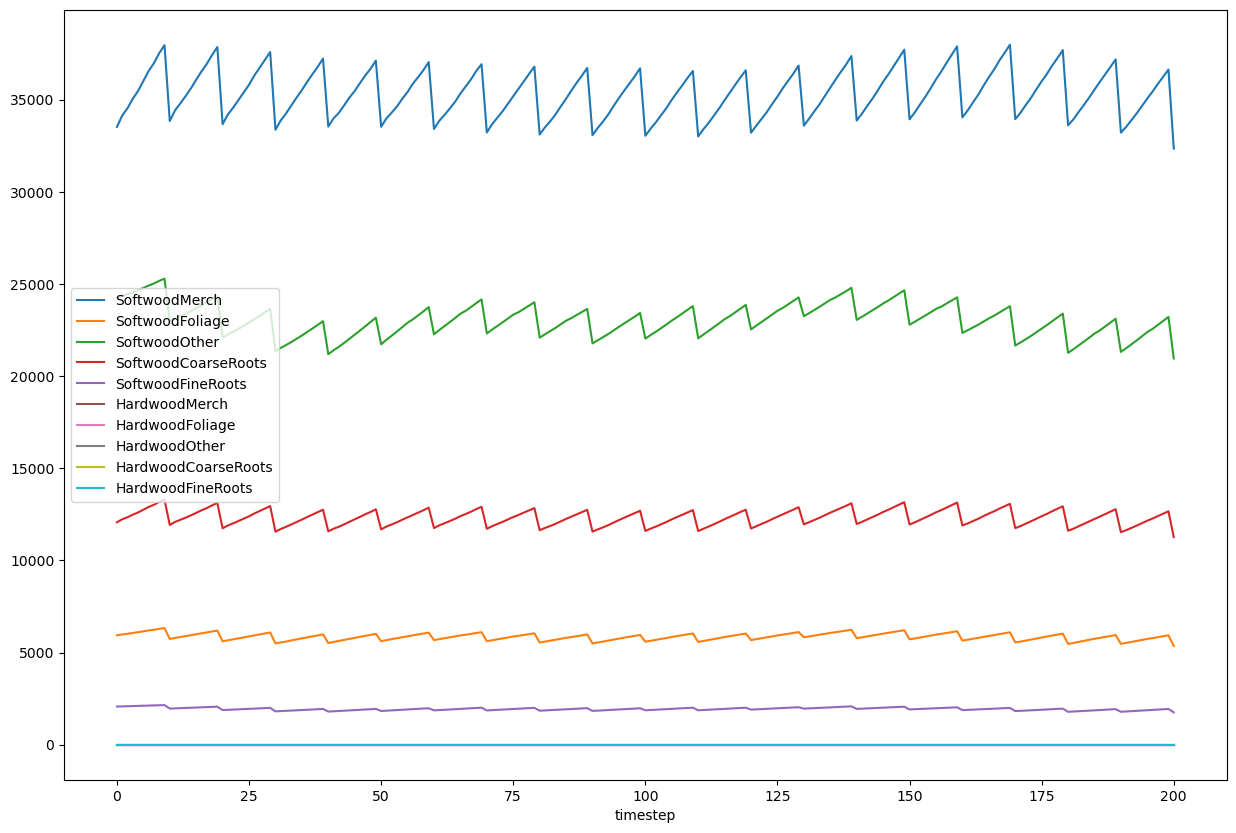

In [79]:
biomass_pools = ['SoftwoodMerch','SoftwoodFoliage', 'SoftwoodOther', 'SoftwoodCoarseRoots', 'SoftwoodFineRoots',
                 'HardwoodMerch', 'HardwoodFoliage', 'HardwoodOther', 'HardwoodCoarseRoots', 'HardwoodFineRoots']

pi[["timestep"]+biomass_pools].groupby("timestep").sum().plot(figsize=(15,10))


,period,co2_ecosystem_emission
0,1,1.416980e+05
1,2,1.695463e+06
2,3,1.974232e+06
3,4,2.453382e+06
4,5,-1.745929e+06
5,6,-4.259040e+06
6,7,-4.130791e+06
7,8,-1.507540e+06
8,9,2.172098e+05
9,10,-5.916042e+05


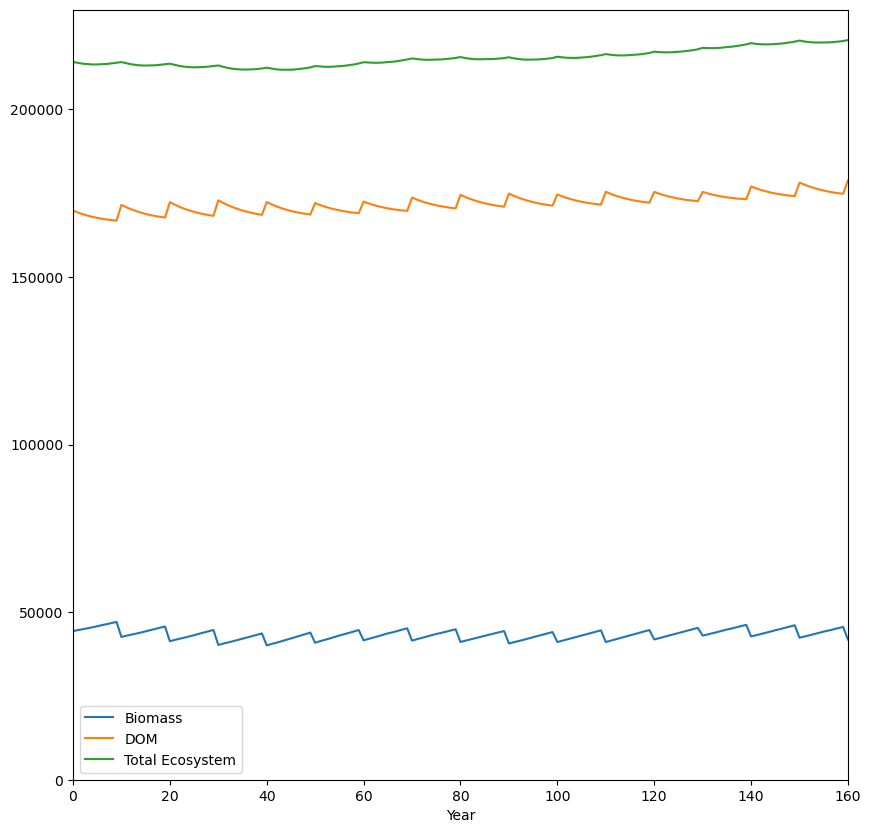

In [80]:
biomass_pools = ['SoftwoodFoliage', 'SoftwoodOther', 'SoftwoodCoarseRoots', 'SoftwoodFineRoots',
                 'HardwoodFoliage', 'HardwoodOther', 'HardwoodCoarseRoots', 'HardwoodFineRoots']

dom_pools = ['AboveGroundVeryFastSoil', 'BelowGroundVeryFastSoil', 'AboveGroundFastSoil', 'BelowGroundFastSoil',
             'MediumSoil', 'AboveGroundSlowSoil', 'BelowGroundSlowSoil', 'SoftwoodStemSnag', 'SoftwoodBranchSnag',
             'HardwoodStemSnag', 'HardwoodBranchSnag']

biomass_result = pi[['timestep']+biomass_pools]
dom_result = pi[['timestep']+dom_pools]
total_eco_result = pi[['timestep']+biomass_pools+dom_pools]

annual_carbon_stocks = pd.DataFrame(
    {
        "Year": pi["timestep"],
        "Biomass": pi[biomass_pools].sum(axis=1),
        "DOM": pi[dom_pools].sum(axis=1),
        "Total Ecosystem": pi[biomass_pools+dom_pools].sum(axis=1)})

annual_carbon_stocks.groupby("Year").sum().plot(figsize=(10,10),xlim=(0,160),ylim=(0,None))

annual_carbon_stocks_year = annual_carbon_stocks.groupby("Year").sum().reset_index()

ecosystem_emission = {'period': [], 'co2_ecosystem_emission': []}

# ecosystem_dynamic = annual_carbon_stocks_year.groupby('period')['Total Ecosystem'].sum().reset_index()

for i in range(0,20):
    ecosystem_emission['period'].append(i+1)
    ecosystem_emission['co2_ecosystem_emission'].append(annual_carbon_stocks_year['Total Ecosystem'].loc[i*10]-annual_carbon_stocks_year['Total Ecosystem'].loc[(i+1)*10])
    

    
df_ecosystem_emission = pd.DataFrame(ecosystem_emission)
df_ecosystem_emission['co2_ecosystem_emission'] = df_ecosystem_emission['co2_ecosystem_emission'] * 1000 * 44 / 12 # 1000 is convert t of c to kg of c, and what's the unit of emission

df_ecosystem_emission
# annual_carbon_stocks_year.head(31)


In [81]:
annual_carbon_stocks_year

,Year,Biomass,DOM,Total Ecosystem
0,0,44306.110944,169833.627525,214139.738469
1,1,44652.544779,169246.206566,213898.751345
2,2,44889.404636,168741.816503,213631.221139
3,3,45195.244018,168308.541366,213503.785383
4,4,45460.201436,167938.144786,213398.346222
...,...,...,...,...
196,196,42506.960434,176496.610375,219003.570809
197,197,42925.875757,176182.735183,219108.610940
198,198,43338.006292,175913.734158,219251.740450
199,199,43747.895141,175685.235281,219433.130422


In [82]:
si = cbm_output.state.to_pandas()

In [83]:
si

,identifier,timestep,last_disturbance_type,time_since_last_disturbance,time_since_land_class_change,growth_enabled,enabled,land_class,age,growth_multiplier,regeneration_delay
0,1,0,harvest,70,70,1,1,0,70,1.0,0
1,2,0,harvest,70,70,1,1,0,70,1.0,0
2,3,0,harvest,70,70,1,1,0,70,1.0,0
3,4,0,harvest,80,80,1,1,0,80,1.0,0
4,5,0,harvest,80,80,1,1,0,80,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...
9492,63,200,harvest,21,330,1,1,0,21,1.0,0
9493,64,200,harvest,11,330,1,1,0,11,1.0,0
9494,65,200,harvest,171,330,1,1,0,171,1.0,0
9495,66,200,harvest,121,280,1,1,0,121,1.0,0


In [84]:
merged_data = cbm_output.classifiers.to_pandas().merge(
    cbm_output.pools.to_pandas(),
    left_index=True,
    right_index=True
).merge(
    cbm_output.state.to_pandas(),
    left_index=True,
    right_index=True
)
# half = len(merged_data) // 2
# df_first_half = merged_data.iloc[:half]
# df_first_half.to_csv('model_result/cbm_flux/pool_inventory_half.csv.gz',compression = 'gzip')

In [85]:
merged_data

,identifier_x,timestep_x,theme0,theme1,theme2,theme3,theme4,species,identifier_y,timestep_y,...,timestep,last_disturbance_type,time_since_last_disturbance,time_since_land_class_change,growth_enabled,enabled,land_class,age,growth_multiplier,regeneration_delay
0,1,0,tsa24_clipped,1,2401002,204,2421002,softwood,1,0,...,0,harvest,70,70,1,1,0,70,1.0,0
1,2,0,tsa24_clipped,1,2401002,204,2421002,softwood,2,0,...,0,harvest,70,70,1,1,0,70,1.0,0
2,3,0,tsa24_clipped,1,2401002,204,2421002,softwood,3,0,...,0,harvest,70,70,1,1,0,70,1.0,0
3,4,0,tsa24_clipped,1,2401002,204,2421002,softwood,4,0,...,0,harvest,80,80,1,1,0,80,1.0,0
4,5,0,tsa24_clipped,1,2401002,204,2421002,softwood,5,0,...,0,harvest,80,80,1,1,0,80,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9492,63,200,tsa24_clipped,1,2401002,204,2421002,softwood,63,200,...,200,harvest,21,330,1,1,0,21,1.0,0
9493,64,200,tsa24_clipped,1,2401002,204,2421002,softwood,64,200,...,200,harvest,11,330,1,1,0,11,1.0,0
9494,65,200,tsa24_clipped,1,2401002,204,2421002,softwood,65,200,...,200,harvest,171,330,1,1,0,171,1.0,0
9495,66,200,tsa24_clipped,1,2401002,204,2421002,softwood,66,200,...,200,harvest,121,280,1,1,0,121,1.0,0


In [86]:
annual_state = pd.DataFrame(
    {
        "Year": merged_data["timestep"],
        "AU": merged_data["theme4"],
        "age": merged_data["time_since_last_disturbance"]})

annual_state

,Year,AU,age
0,0,2421002,70
1,0,2421002,70
2,0,2421002,70
3,0,2421002,80
4,0,2421002,80
...,...,...,...
9492,200,2421002,21
9493,200,2421002,11
9494,200,2421002,171
9495,200,2421002,121


In [87]:
fi = cbm_output.flux.to_pandas()

fi

,identifier,timestep,DisturbanceCO2Production,DisturbanceCH4Production,DisturbanceCOProduction,DisturbanceBioCO2Emission,DisturbanceBioCH4Emission,DisturbanceBioCOEmission,DecayDOMCO2Emission,DisturbanceSoftProduction,...,DisturbanceVFastBGToAir,DisturbanceFastAGToAir,DisturbanceFastBGToAir,DisturbanceMediumToAir,DisturbanceSlowAGToAir,DisturbanceSlowBGToAir,DisturbanceSWStemSnagToAir,DisturbanceSWBranchSnagToAir,DisturbanceHWStemSnagToAir,DisturbanceHWBranchSnagToAir
0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9492,63,200,0.0,0.0,0.0,0.0,0.0,0.0,16.856809,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9493,64,200,0.0,0.0,0.0,0.0,0.0,0.0,38.876032,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9494,65,200,0.0,0.0,0.0,0.0,0.0,0.0,31.944290,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9495,66,200,0.0,0.0,0.0,0.0,0.0,0.0,10.987619,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [88]:
# fi.to_csv('model_result/cbm_flux/flux.csv',index=False)

In [89]:
# # Sequential Difference Approach
# # Create a new 'year' column
# fi['year'] = fi['timestep']

# # emission_columns = [
# #     'DecayVFastAGToAir',
# #     'DecayVFastBGToAir',
# #     'DecayFastAGToAir',
# #     'DecayFastBGToAir',
# #     'DecayMediumToAir',
# #     'DecaySlowAGToAir',
#     # 'DecaySlowBGToAir',
# #     'DecaySWStemSnagToAir',
# #     'DecaySWBranchSnagToAir',
# #     'DecayHWStemSnagToAir',
# #     'DecayHWBranchSnagToAir'
# # ]

# emission_columns = ['DecayDOMCO2Emission']
# # Create a new 'total_decay' column that is the sum of the decay columns
# fi['total_decay'] = fi[emission_columns].sum(axis=1)

# df_eco_decay = fi[['total_decay', 'year']].groupby('year').sum()

# df_eco_decay = df_eco_decay.reset_index()

# #following is the sequential difference method

# df_eco_decay = df_eco_decay.sort_values(by='year')
# df_eco_decay['dom_emission_difference'] = df_eco_decay['total_decay'].diff() 
# df_eco_decay.fillna(0,inplace = True)
# df_eco_decay['co2_dom_emission'] = df_eco_decay['dom_emission_difference'] * 1000 * 44 / 12 


# df_eco_decay

# df_eco_decay['period'] = (df_eco_decay['year'] // 10) * 10

# df_eco_emission = df_eco_decay.groupby('period')['co2_dom_emission'].sum().reset_index()

# df_eco_emission = df_eco_emission[df_eco_emission['period'] != 0].reset_index(drop=True)

# # df_eco_decay
# df_eco_decay


In [90]:
annual_process_fluxes = [
    'DecayDOMCO2Emission',
    # 'DeltaBiomass_AG',
    # 'DeltaBiomass_BG',
    # 'TurnoverMerchLitterInput',
    # 'TurnoverFolLitterInput',
    # 'TurnoverOthLitterInput',
    # 'TurnoverCoarseLitterInput',
    # 'TurnoverFineLitterInput',
    'DecayVFastAGToAir',
    'DecayVFastBGToAir',
    'DecayFastAGToAir',
    'DecayFastBGToAir',
    'DecayMediumToAir',
    'DecaySlowAGToAir',
    'DecaySlowBGToAir',
    'DecaySWStemSnagToAir',
    'DecaySWBranchSnagToAir',
    'DecayHWStemSnagToAir',
    'DecayHWBranchSnagToAir']

<AxesSubplot:xlabel='timestep'>

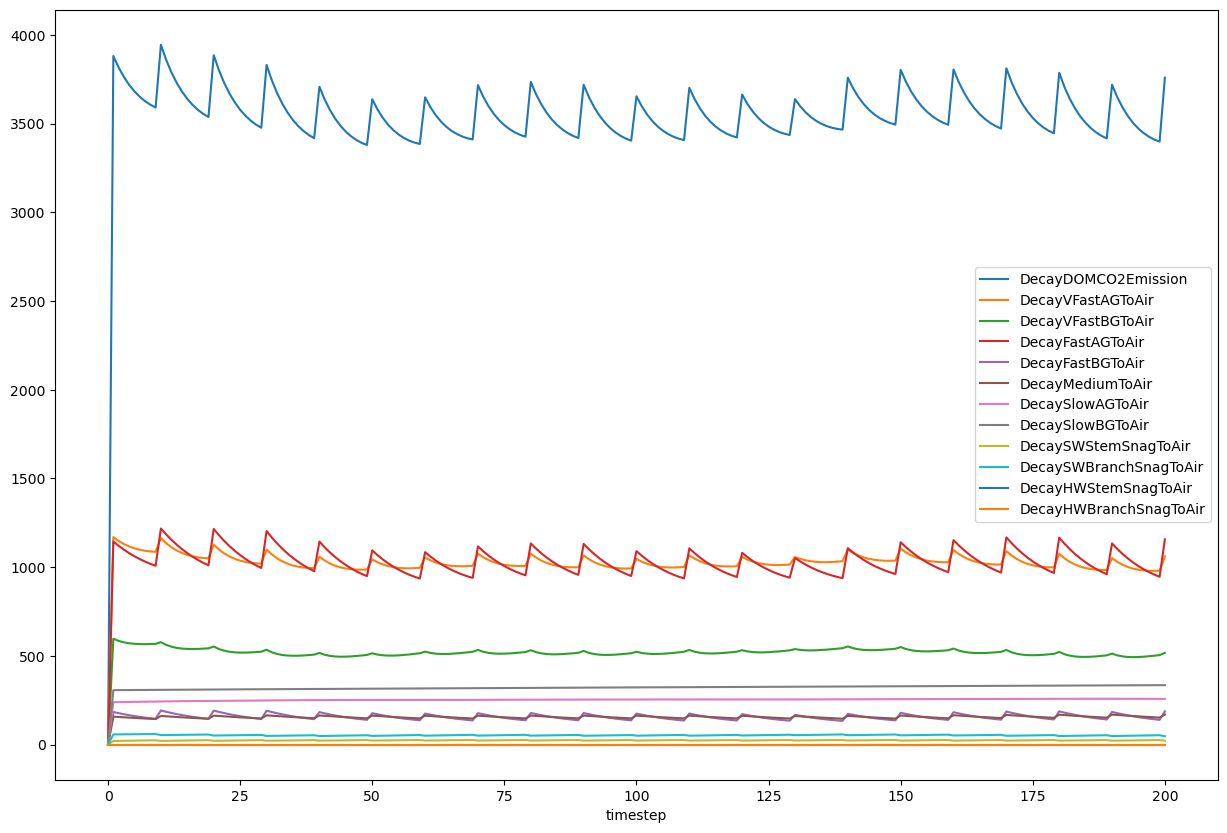

In [91]:
fi[["timestep"]+annual_process_fluxes].groupby("timestep").sum().plot(figsize=(15,10))

In [92]:
# Cumulative Difference Approach
# Create a new 'year' column
fi['year'] = fi['timestep']

# emission_columns = [
#     'DecayVFastAGToAir',
#     'DecayVFastBGToAir',
#     'DecayFastAGToAir',
#     'DecayFastBGToAir',
#     'DecayMediumToAir',
#     'DecaySlowAGToAir',
#     'DecaySlowBGToAir',
#     'DecaySWStemSnagToAir',
#     'DecaySWBranchSnagToAir',
#     'DecayHWStemSnagToAir',
#     'DecayHWBranchSnagToAir'
# ]

emission_columns = ['DecayDOMCO2Emission']
# Create a new 'total_decay' column that is the sum of the decay columns
fi['total_decay'] = fi[emission_columns].sum(axis=1)

df_eco_decay = fi[['total_decay', 'year']].groupby('year').sum()

df_eco_decay = df_eco_decay.reset_index()

#following is the sequential difference method

# df_eco_decay = df_eco_decay.sort_values(by='year')
# df_eco_decay['dom_emission_difference'] = df_eco_decay['total_decay'].diff() 
# df_eco_decay.fillna(0,inplace = True)
df_eco_decay['co2_dom_emission'] = df_eco_decay['total_decay'] * 1000 * 44 / 12 


df_eco_decay

df_eco_decay['period'] = (df_eco_decay['year'] // 10) * 10

df_eco_emission = df_eco_decay.groupby('period')['co2_dom_emission'].sum().reset_index()

df_eco_emission = df_eco_emission[df_eco_emission['period'] != 0].reset_index(drop=True)

# df_eco_decay
df_eco_decay


,year,total_decay,co2_dom_emission,period
0,0,0.000000,0.000000e+00,0
1,1,3880.551209,1.422869e+07,0
2,2,3815.805237,1.399129e+07,0
3,3,3762.144848,1.379453e+07,0
4,4,3717.669099,1.363145e+07,0
...,...,...,...,...
196,196,3445.620149,1.263394e+07,190
197,197,3425.323674,1.255952e+07,190
198,198,3409.643884,1.250203e+07,190
199,199,3397.917247,1.245903e+07,190


In [93]:
GrossGrowth = [
    "DeltaBiomass_AG",
    "TurnoverMerchLitterInput",
    "TurnoverFolLitterInput",
    "TurnoverOthLitterInput",
    "DeltaBiomass_BG",
    "TurnoverCoarseLitterInput",
    "TurnoverFineLitterInput",
]

# Assuming fi is your DataFrame
fi['total_growth'] = fi[GrossGrowth].sum(axis=1)

# Group by 'year' and sum
df_eco_growth = fi[['total_growth', 'year']].groupby('year').sum()

# Reset index and calculate 'co2_seq'
df_eco_growth = df_eco_growth.reset_index()
df_eco_growth['co2_seq'] = df_eco_growth['total_growth'] * 1000 * 44 / 12 

# Define periods (grouping years into decades)
df_eco_growth['period'] = (df_eco_growth['year'] // 10) * 10

# Group by 'period' and sum 'co2_seq'
df_carbon_seq = df_eco_growth.groupby('period')['co2_seq'].sum().reset_index()

# Optional: Filter out periods where 'period' is 0 (if needed)
df_carbon_seq = df_carbon_seq[df_carbon_seq['period'] != 0].reset_index(drop=True)

df_carbon_seq

,period,co2_seq
0,10,1.477867e+08
1,20,1.444352e+08
2,30,1.415082e+08
3,40,1.418771e+08
4,50,1.438031e+08
5,60,1.444666e+08
6,70,1.434293e+08
7,80,1.419305e+08
8,90,1.416921e+08
9,100,1.434394e+08


In [94]:
rule_based_processor.sit_event_stats_by_timestep[1]

In [95]:
rule_based_processor.sit_events

,theme0,theme1,theme2,theme3,theme4,species,min_age,max_age,MinYearsSinceDist,MaxYearsSinceDist,...,MinHWMerchStemSnagC,MaxHWMerchStemSnagC,efficiency,sort_type,target_type,target,disturbance_type,time_step,disturbance_type_id,sort_field
0,tsa24_clipped,1,2401002,204,2421002,softwood,139,141,-1,-1,...,-1,-1,1,MERCHCSORT_TOTAL,Area,54.033045,harvest,10,1,1
1,tsa24_clipped,1,2401002,204,2421002,softwood,139,141,-1,-1,...,-1,-1,1,MERCHCSORT_TOTAL,Area,1.977879,harvest,10,1,1
2,tsa24_clipped,1,2401002,204,2421002,softwood,149,151,-1,-1,...,-1,-1,1,MERCHCSORT_TOTAL,Area,8.859900,harvest,10,1,1
3,tsa24_clipped,1,2401002,204,2421002,softwood,149,151,-1,-1,...,-1,-1,1,MERCHCSORT_TOTAL,Area,0.740100,harvest,10,1,1
4,tsa24_clipped,1,2401002,204,2421002,softwood,159,161,-1,-1,...,-1,-1,1,MERCHCSORT_TOTAL,Area,34.300000,harvest,10,1,1
5,tsa24_clipped,1,2401002,204,2421002,softwood,149,151,-1,-1,...,-1,-1,1,MERCHCSORT_TOTAL,Area,13.494231,harvest,20,1,1
6,tsa24_clipped,1,2401002,204,2421002,softwood,149,151,-1,-1,...,-1,-1,1,MERCHCSORT_TOTAL,Area,84.658054,harvest,20,1,1
7,tsa24_clipped,1,2401002,204,2421002,softwood,139,141,-1,-1,...,-1,-1,1,MERCHCSORT_TOTAL,Area,47.997474,harvest,30,1,1
8,tsa24_clipped,1,2401002,204,2421002,softwood,139,141,-1,-1,...,-1,-1,1,MERCHCSORT_TOTAL,Area,34.972066,harvest,30,1,1
9,tsa24_clipped,1,2401002,204,2421002,softwood,159,161,-1,-1,...,-1,-1,1,MERCHCSORT_TOTAL,Area,14.436791,harvest,30,1,1


In [96]:
df_emission_calculation = df_product[['period']].join([df_product.drop('period', axis=1),
                                                       df_operation_area.drop('period', axis=1),
                                                       df_carbon_seq.drop('period', axis=1),
                                                       df_ecosystem_emission.drop('period', axis=1),
                                                       df_eco_emission.drop('period', axis=1)])
# exp_name = 'dom_cumulative'
df_emission_calculation.to_csv(f"model_result/emission_calculation/emission_calculation_{model_name}_{exp_name}_{scenario_name}_{float(inventory_retention)}.csv")
print(f"model_result/emission_calculation/emission_calculation_{model_name}_{exp_name}_{scenario_name}_{float(inventory_retention)}.csv")
df_emission_calculation

model_result/emission_calculation/emission_calculation_tsa24_clipped_dom_cumulative_base_1.0.csv


,period,plumber,pbark,pchips,psawdust,pshaving,ptrim,oha,fert_area,co2_seq,co2_ecosystem_emission,co2_dom_emission
0,1,17598.139716,733.676469,2376.151256,499.554621,243.721848,143.810924,99.910924,0.0,1.477867e+08,1.416980e+05,1.353340e+08
1,2,17550.983600,687.065994,2355.654836,490.761424,294.456855,196.304570,98.152285,0.0,1.444352e+08,1.695463e+06,1.331134e+08
2,3,17622.997688,734.681108,2384.419195,512.631655,222.049453,121.443122,100.606331,0.0,1.415082e+08,1.974232e+06,1.310042e+08
3,4,15875.769674,639.325440,2097.356027,459.562533,250.296496,173.066607,77.229889,0.0,1.418771e+08,2.453382e+06,1.282963e+08
4,5,15827.213544,662.492729,2044.417271,474.766162,238.839595,176.216668,59.709899,0.0,1.438031e+08,-1.745929e+06,1.273797e+08
5,6,15246.081056,625.644651,2005.005625,458.676027,257.398470,177.368624,60.829846,0.0,1.444666e+08,-4.259040e+06,1.280947e+08
6,7,15806.400410,679.551552,2111.631540,428.708740,250.842812,169.887888,80.954924,0.0,1.434293e+08,-4.130791e+06,1.294644e+08
7,8,15803.372004,670.135233,2123.678504,418.834520,251.300712,167.533808,83.766904,0.0,1.419305e+08,-1.507540e+06,1.295889e+08
8,9,15786.568048,665.009090,2120.247588,418.203091,249.378409,166.252273,80.553727,0.0,1.416921e+08,2.172098e+05,1.290154e+08
9,10,16405.877258,699.907108,2118.103248,478.454880,281.107410,167.519879,53.932349,0.0,1.434394e+08,-5.916042e+05,1.281384e+08
